#  LightGBM and XGBoost Stacked
Logistic Regression ran on top of two models. Preprocessing too.

## Imports

In [72]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import KFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as acc
from scipy.stats import hmean 
from numpy import argmax
from sklearn.metrics import roc_auc_score as ras
from sklearn.linear_model import LogisticRegression as lr

## Reading Data
#### ...and some simple analysis.

In [73]:
df_test=pd.read_csv('test.csv')
df_train=pd.read_csv('train.csv')

In [74]:
#checking for null values
df_train.isnull().values.any()

False

In [75]:
df_train.shape

(31649, 18)

In [76]:
df_test.shape

(13562, 17)

In [77]:
df_test.head()

,serial_number,age_in_years,job_description,marital_status,education_details,has_default,balance_in_account,housing_status,previous_loan,phone_type,date,month_of_year,call_duration,campaign_contacts,days_passed,previous_contact,poutcome_of_campaign
0,1,33,admin.,married,secondary,no,796,yes,no,telephone,6,apr,216,1,-1,0,unknown
1,2,40,management,married,secondary,no,754,no,yes,cellular,6,apr,635,1,-1,0,unknown
2,3,30,technician,single,secondary,no,10152,yes,no,cellular,6,apr,1108,2,270,1,failure
3,4,44,blue-collar,married,secondary,no,545,yes,no,cellular,6,apr,122,3,136,1,failure
4,5,35,technician,married,secondary,no,5553,yes,no,cellular,6,apr,371,3,136,7,failure


In [78]:
df_train.head()

,serial_number,age_in_years,job_description,marital_status,education_details,has_default,balance_in_account,housing_status,previous_loan,phone_type,date,month_of_year,call_duration,campaign_contacts,days_passed,previous_contact,poutcome_of_campaign,outcome
0,1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,4,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,5,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


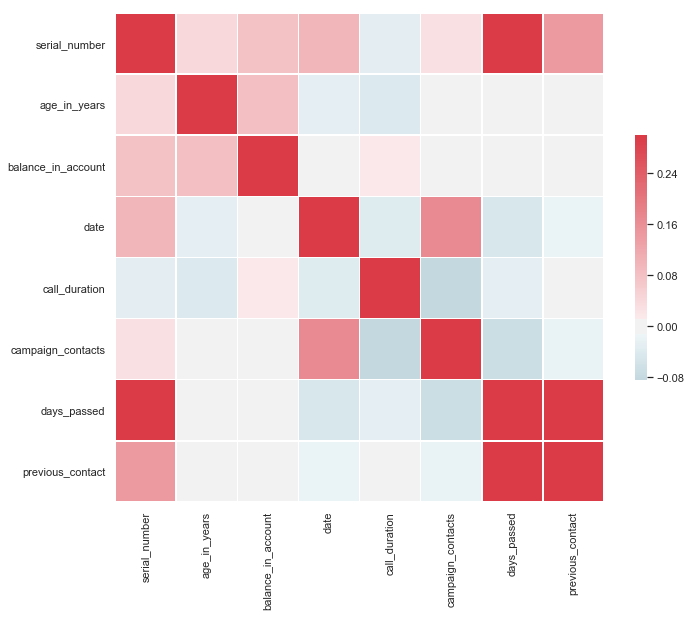

In [79]:
sns.set(style="white")
corr = df_train.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Feature Processing
handling unknown data.

In [80]:
dataset_new=df_train
test_final=df_test
def impute_unknowns(df, column):
    col_values = df[column].values
    df[column] = np.where(col_values=='unknown', df_train[column].mode(), col_values)
    return df
dataset_new = impute_unknowns(df=dataset_new, column='job_description')
dataset_new = impute_unknowns(df=dataset_new, column='education_details')
test_final = impute_unknowns(df=df_test, column='job_description')
test_final = impute_unknowns(df=test_final, column='education_details')

## Data separation

In [81]:
frame_sno = test_final['serial_number'] #serial numbers
frame_train_target = pd.DataFrame(dataset_new['outcome']) #Y of train
frame_train = dataset_new.drop(['outcome','serial_number','month_of_year', 'date', 'poutcome_of_campaign', 'phone_type'], axis = 1) #X array of train
frame_test = test_final.drop(['serial_number','month_of_year', 'date', 'poutcome_of_campaign', 'phone_type'], axis = 1) #testdata array
frame_test.shape

(13562, 12)

## Adopting Ninjarao's Encoding

### Target Variable

In [82]:
encoder= LabelEncoder()
dataset_encoded= encoder.fit_transform(frame_train_target['outcome'])
dataset_encoded
frame_train_target['outcome']=dataset_encoded


In [83]:
frame_train_target.drop_duplicates()

,outcome
0,0
83,1


### Binary features

In [84]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in frame_train:
    if frame_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(frame_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(frame_train[col])
            # Transform both training and testing data
            frame_train[col] = le.transform(frame_train[col])
            frame_test[col] = le.transform(frame_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


3 columns were label encoded.


### One hot for other categoricals

In [85]:
frame_train = pd.get_dummies(frame_train)#One hot encoding(Prolly better ways of doing this)
frame_test = pd.get_dummies(frame_test)

train_labels = frame_train_target
# Align the training and testing data, keep only columns present in both dataframes
frame_train, frame_test = frame_train.align(frame_test, join = 'inner', axis = 1)

# Add the target back in
#frame_train['outcome'] = train_labels

print('Training Features shape: ', frame_train.shape)
print('Testing Features shape: ', frame_test.shape)



Training Features shape:  (31649, 26)
Testing Features shape:  (13562, 26)


### Viewing

In [86]:
#frame_train

## Conversion into arrays for K-Fold

In [87]:
sno = frame_sno.values 
train_target = frame_train_target.values
train = np.array(frame_train) 
test = np.array(frame_test) 
frame_train.shape

(31649, 26)

## K-Fold

In [88]:
K=10
kf = KFold(n_splits=K, random_state=42)

y_tests=[] #will be used for averaging model predictions SCORES

#LGBM
lscore_preds=[] #holds predictions made for scoring
lgb_preds=[] #will hold the k folds of predictions
lscores=[] #will hold accuracy score of each fold
laucs=[] #will hold AUC score of each fold

#XGBOOST
xscore_preds=[]
xgb_preds = []
xscores=[]
xaucs=[]

#Logreg
log_preds=[]


param_dist = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.035,
    'metric': ['auc'],
    'is_training_metric' : True,
    'tree_leaner': 'data',
    'feature_fraction_seed' : 42,
    'verbose':0,
    'feature_fraction':0.85,
    'bagging_fraction': 0.45,
    'bagging_freq':7,
    # 'bagging_seed': 42,
    'l2_lambda':14,
    #'l1_lambda': 16,
    'num_leaves': 1024,
    'min_data_in_leaf':40,
    'min_gain_to_split':1,
    # 'max_bin' :300
} 

for train_index, test_index in kf.split(train, train_target):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train[train_index], train[test_index]
    y_train, y_test = train_target[train_index].flatten(), train_target[test_index].flatten()
    
    
    
    
    #LGBM
    
    #lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=True)
    #lgb_val = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=True)

    #lmodel = lgb.train(param_dist,
    #                lgb_train,
    #                num_boost_round = 40,
    #                valid_sets = lgb_val,
    #                early_stopping_rounds=12)
    
    lmodel=lgb.LGBMClassifier(n_estimators=400)
    lmodel.fit(X_train, y_train)
    
    lgb_pred = lmodel.predict_proba(test)[:,1]
    lgb_preds.append(lgb_pred)

    lscore_pred = lmodel.predict_proba(X_test)[:,1]
    #scoring
    lscore_preds.append(list(lscore_pred))
    
    lrounded = np.array(lscore_pred)
    #print(lrounded)
    mid=0.5
    lrounded[lrounded >= mid] = 1
    lrounded[lrounded < mid] = 0
    #print(lrounded)
    
    lscore=acc(y_test, lrounded)
    lauc=ras(y_test,lscore_pred)
    
    print('L_Score: ', lscore)
    print('L_AUC score: ', lauc)
    lscores.append(lscore)
    laucs.append(lauc)
    
    
    #XGBOOST
    xgb_params = {
        'eta': 0.05,
        'max_depth': 4,
        'subsample': 0.9,
        'objective': 'binary:logistic',
        'silent': 1,
        'colsample_bytree': 0.8,
        #'lambda':1.2,
        
        #'min_child_weight': 0.9,
        #'max_delta_step': 1.8,
        #'colsample_bytree': 0.7,
        #'eta': 0.025,
        #'gamma': 0.1,
    }


    #d_train = xgb.DMatrix(X_train, y_train)
    #d_valid = xgb.DMatrix(X_test)
    #d_test = xgb.DMatrix(test)
    
    
    #xmodel = xgb.train(xgb_params, d_train, num_boost_round = 190, maximize=True)
    xmodel = xgb.XGBClassifier(max_depth=7, learning_rate=0.2, n_estimators=200)
    xmodel.fit(X_train, y_train)
    
    xgb_pred = xmodel.predict_proba(test)[:,1]
    xgb_preds.append(list(xgb_pred))
    
    
    
    
    
    #scoring
    xscore_pred = xmodel.predict_proba(X_test)[:,1]
    xscore_preds.append(list(xscore_pred))
    #pd.DataFrame(score_pred)
    
    xrounded = np.array(xscore_pred)
   
    mid=0.5
    xrounded[xrounded >= mid] = 1
    xrounded[xrounded < mid] = 0
    
    
    xscore=acc(y_test, xrounded)
    xauc=ras(y_test, xscore_pred)
    
    print('X_Score: ', xscore)
    print('X_AUC score: ', xauc)
    xscores.append(xscore)
    xaucs.append(xauc)
    

    
    y_tests.append(list(y_test))
    
    
    #LOGREG
    
    #training
    data={'lgb':lscore_pred,'xgb':xscore_pred}
    fittable=pd.DataFrame(data)
    clf = lr()
    #print(fittable)
    clf.fit(fittable,y_test)

    
    
    #predicting test data
    data={'lgb':lgb_pred,'xgb':xgb_pred}
    predictable=pd.DataFrame(data)
    #print(lgb_pred)
    #print(xgb_pred)
    #print(predictable)
    log_pred=clf.predict_proba(predictable)
    log_pred = log_pred[:, 1]
    
    
    log_preds.append(list(log_pred))
    

TRAIN: [ 3165  3166  3167 ... 31646 31647 31648] TEST: [   0    1    2 ... 3162 3163 3164]
L_Score:  0.9680884676145339
L_AUC score:  0.959350927422332
X_Score:  0.9658767772511848
X_AUC score:  0.9570169897536445
TRAIN: [    0     1     2 ... 31646 31647 31648] TEST: [3165 3166 3167 ... 6327 6328 6329]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


L_Score:  0.9589257503949447
L_AUC score:  0.952351020453572
X_Score:  0.9560821484992101
X_AUC score:  0.9510187848008322
TRAIN: [    0     1     2 ... 31646 31647 31648] TEST: [6330 6331 6332 ... 9492 9493 9494]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


L_Score:  0.953870458135861
L_AUC score:  0.9409852096320742
X_Score:  0.9529225908372828
X_AUC score:  0.9408483070529274
TRAIN: [    0     1     2 ... 31646 31647 31648] TEST: [ 9495  9496  9497 ... 12657 12658 12659]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


L_Score:  0.958609794628752
L_AUC score:  0.9480283583913948
X_Score:  0.9579778830963666
X_AUC score:  0.9483437232612151
TRAIN: [    0     1     2 ... 31646 31647 31648] TEST: [12660 12661 12662 ... 15822 15823 15824]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


L_Score:  0.9387045813586098
L_AUC score:  0.9358790801652789
X_Score:  0.9352290679304898
X_AUC score:  0.9341914396593948
TRAIN: [    0     1     2 ... 31646 31647 31648] TEST: [15825 15826 15827 ... 18987 18988 18989]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


L_Score:  0.9462875197472354
L_AUC score:  0.9445212121212121
X_Score:  0.9513428120063191
X_AUC score:  0.9444242424242424
TRAIN: [    0     1     2 ... 31646 31647 31648] TEST: [18990 18991 18992 ... 22152 22153 22154]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


L_Score:  0.9393364928909953
L_AUC score:  0.9448784358948128
X_Score:  0.9399684044233807
X_AUC score:  0.94291307461243
TRAIN: [    0     1     2 ... 31646 31647 31648] TEST: [22155 22156 22157 ... 25317 25318 25319]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


L_Score:  0.9469194312796209
L_AUC score:  0.8566998691564751
X_Score:  0.9459715639810427
X_AUC score:  0.8627050575182084
TRAIN: [    0     1     2 ... 31646 31647 31648] TEST: [25320 25321 25322 ... 28482 28483 28484]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


L_Score:  0.9368088467614534
L_AUC score:  0.9029483210640914
X_Score:  0.9409162717219589
X_AUC score:  0.9040888421489195
TRAIN: [    0     1     2 ... 28482 28483 28484] TEST: [28485 28486 28487 ... 31646 31647 31648]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


L_Score:  0.8723135271807838
L_AUC score:  0.7347302633597321
X_Score:  0.8691529709228825
X_AUC score:  0.7276380896448653


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Averaging Stack Output

In [89]:
logavg=hmean(log_preds)
len(logavg)

13562

In [90]:
avg=logavg

## Preparing the submission

### *Rounding averaged values & decoding*

In [91]:
mid=0.5
avg[avg >= mid] = 1
avg[avg < mid] = 0

In [92]:

sub=pd.DataFrame({'outcome':avg})


In [93]:
sub[sub['outcome']==1.0]='yes'
sub[sub['outcome']==0.0]='no'
sub.drop_duplicates()

,outcome
0,no
11,yes


In [94]:
sub[sub['outcome']=='no'].shape[0]/sub.shape[0] #percentage of no

0.9747824804601092

In [95]:
sub['serial_number']=sno
sub=sub[['serial_number','outcome']]

In [96]:
sub.head()

,serial_number,outcome
0,1,no
1,2,no
2,3,no
3,4,no
4,5,no


In [97]:
sub.to_csv("sub_lgbm_xgb_stacked_prep3.csv", index=False)